## Import Packages

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Prepare the Dataset

In [26]:
# Load the data
df = pd.read_csv("prices.csv")

# make the Date column as datetime data type
df['Date'] = pd.to_datetime(df['Date'])

# make the date feature as the index of the df
df.index = df.pop("Date")

# prepare the the dates and the prices values as arrays
time = np.array(df.index)
series = np.array(df['Price'])

## Define Functions

#### `plot_series` function

In [27]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

#### `windowed_dataset` function

In [28]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

#### `model_forecast` function

In [29]:
def model_forecast(model, series, window_size, batch_size):
    """
    Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
  
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

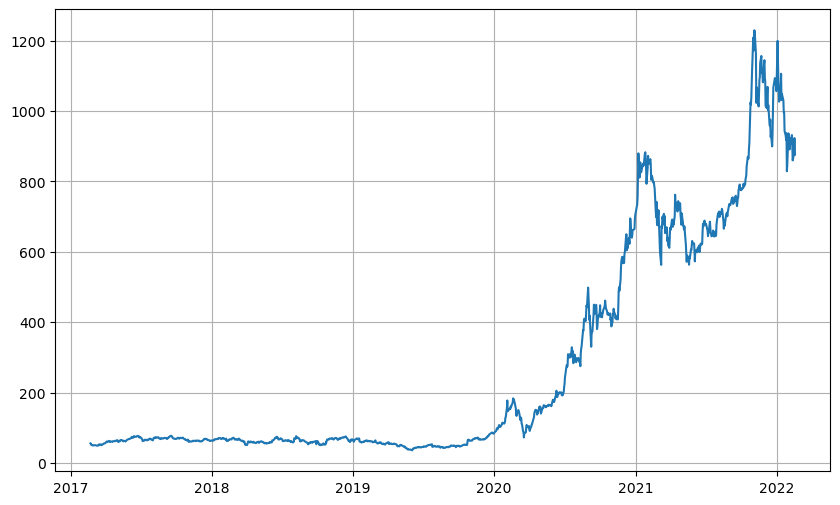

In [30]:
plot_series(time, series)

## Prepare the Data

In [31]:
# the index for the 80th quantile value, "THE SPLITTING INDEX"
split_time_start_train = int(len(time) * 0.4)
split_time_end_train = int(len(time) * 0.9)
split_time_test = int(len(time) * 0.8)

# Prepare the training data
time_train = time[split_time_start_train:split_time_end_train]
x_train = series[split_time_start_train: split_time_end_train]

# Prepare the Testing data
time_test = time[split_time_test:]
x_test = series[split_time_test:]

# Parameters for the `windowed_dataset` function & for the model
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [32]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 128)           98816     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

#### Schedule the `Learning Rate` value

In [33]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
20/20 [==============================] - 3s 36ms/step - loss: 251.7833 - lr: 1.0000e-06
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 248.9562 - lr: 1.1220e-06
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 245.8801 - lr: 1.2589e-06
Epoch 4/100
20/20 [==============================] - 0s 13ms/step - loss: 242.3608 - lr: 1.4125e-06
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 238.3483 - lr: 1.5849e-06
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 234.0745 - lr: 1.7783e-06
Epoch 7/100
20/20 [==============================] - 0s 15ms/step - loss: 229.3510 - lr: 1.9953e-06
Epoch 8/100
20/20 [==============================] - 0s 13ms/step - loss: 224.1249 - lr: 2.2387e-06
Epoch 9/100
20/20 [==============================] - 0s 14ms/step - loss: 218.3509 - lr: 2.5119e-06
Epoch 10/100
20/20 [==============================] - 0s 14ms/step - loss: 212.4634 - lr: 2.8184e-06

#### Plot the `loss` with `learning rate` values

(1e-08, 0.001, 0.0, 100.0)

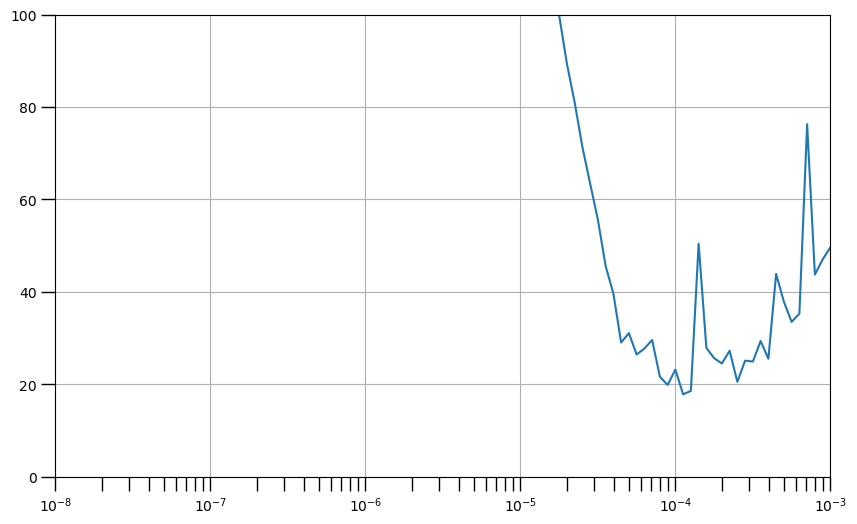

In [34]:
# Define the learning rate array
lrs = 1e-6 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

#### Train the Model with the appropriate `Hyperparameters` values

In [54]:
# Reset states generated by Keras & reset weights
tf.keras.backend.clear_session()
model.set_weights(init_weights)

# Set the learning rate with the oprimizer
learning_rate = 2e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss='mae',
              optimizer=optimizer,
              metrics=tf.keras.metrics.RootMeanSquaredError(name='rmse'))

# Train the model
history = model.fit(train_set,epochs=50)

Epoch 1/50
20/20 [==============================] - 3s 17ms/step - loss: 166.4978 - rmse: 260.0185
Epoch 2/50
20/20 [==============================] - 0s 15ms/step - loss: 81.9465 - rmse: 135.1270
Epoch 3/50
20/20 [==============================] - 0s 15ms/step - loss: 39.4237 - rmse: 71.0307
Epoch 4/50
20/20 [==============================] - 0s 14ms/step - loss: 27.7289 - rmse: 41.6822
Epoch 5/50
20/20 [==============================] - 0s 14ms/step - loss: 24.4400 - rmse: 37.3226
Epoch 6/50
20/20 [==============================] - 0s 14ms/step - loss: 22.2985 - rmse: 34.8576
Epoch 7/50
20/20 [==============================] - 0s 14ms/step - loss: 19.3469 - rmse: 32.1729
Epoch 8/50
20/20 [==============================] - 0s 15ms/step - loss: 18.4603 - rmse: 31.4756
Epoch 9/50
20/20 [==============================] - 0s 14ms/step - loss: 45.0212 - rmse: 68.9086
Epoch 10/50
20/20 [==============================] - 0s 14ms/step - loss: 21.2898 - rmse: 36.7170
Epoch 11/50
20/20 [=======

#### Plot the `loss` and the `metrics` (`MAE & RMSE`)

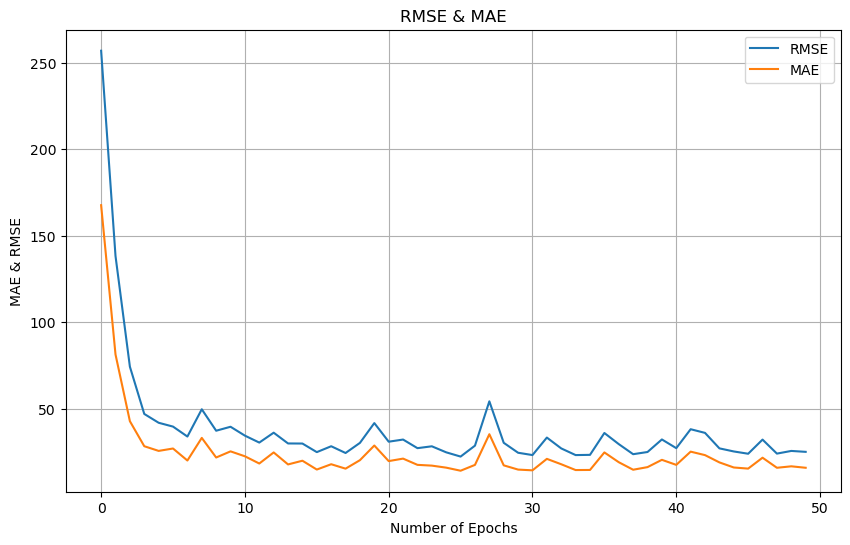

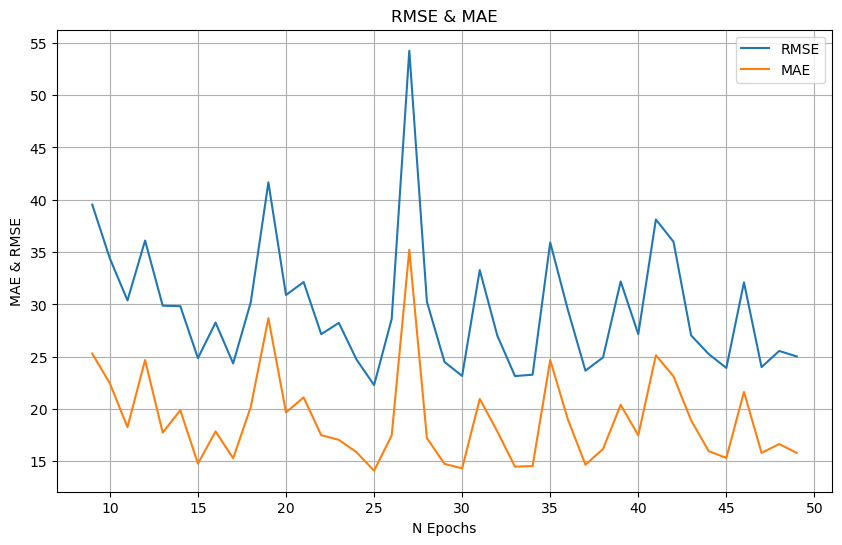

In [36]:
# Get mae and loss from history log
rmse=history.history['rmse']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(rmse, loss), 
    title='RMSE & MAE', 
    xlabel='Number of Epochs',
    ylabel='MAE & RMSE',
    legend=['RMSE', 'MAE']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
rmse_zoom = rmse[zoom_split:]
mae_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(rmse_zoom, mae_zoom), 
    title='RMSE & MAE', 
    xlabel='N Epochs',
    ylabel='MAE & RMSE',
    legend=['RMSE', 'MAE']
    )

#### Make Prediction on the **Testing Data** with the `MAE`

8/8 [==============================] - 0s 7ms/step
MAE Test: 93.81
RMSE Test: 115.28


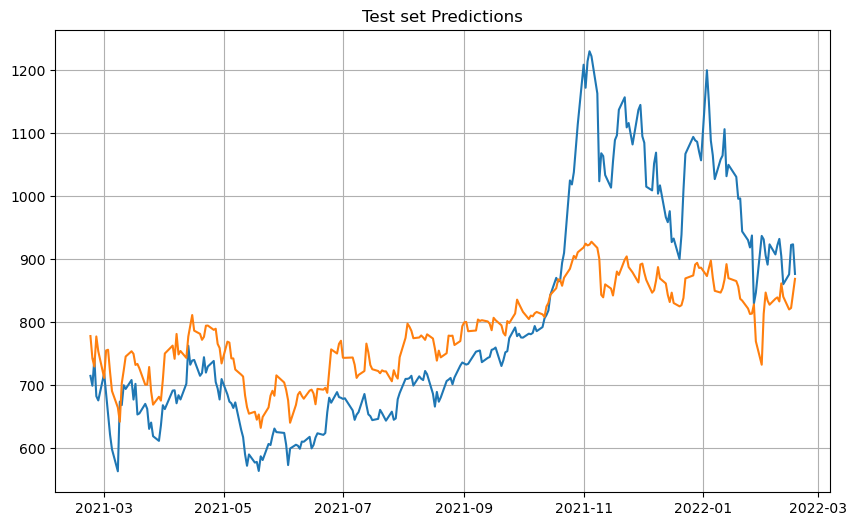

In [52]:
# Reduce the original series
forecast_series = series[split_time_test-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Compute the MAE
print(f"MAE Test: {mean_absolute_error(x_test, results):.2f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(x_test, results)):.2f}")

# Plot the results
plot_series(time_test, (x_test, results), title="Test set Predictions")

#### Make Prediction on the **Training Data** with `MAE`

20/20 [==============================] - 0s 7ms/step
MAE Train: 24.84
RMSE Train: 37.15


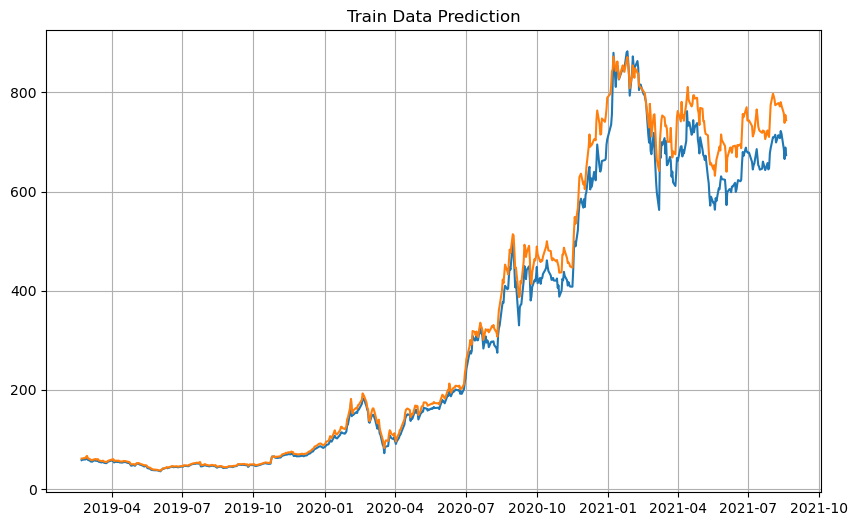

In [53]:
# Expand the original series
train_forcast_series = series[split_time_start_train-window_size+1:split_time_end_train]

# Use helper function to generate predictions
train_forcast = model_forecast(model, train_forcast_series, window_size, batch_size)

# Drop single dimensional axis
train_result = train_forcast.squeeze()

# Compute the MAE
print(f"MAE Train: {mean_absolute_error(x_train, train_result):.2f}")
print(f"RMSE Train: {np.sqrt(mean_squared_error(x_train,train_result)):0.2f}")

# Plot the results
plot_series(time_train, (x_train, train_result), title="Train Data Prediction")